In [183]:
# These imports and path modifications are only necessary for development
import importlib

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [184]:
!pip install pandas scanpy anndata numpy seaborn matplotlib scipy 
!pip install pprintpp

In [185]:
pip install --upgrade scipy


Note: you may need to restart the kernel to use updated packages.


In [186]:
!pip install KDEpy

In [187]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [188]:
import pprintpp as pp

# BacSC general pipeline - Tutorial

This tutorial covers how to use the BacSC pipeline to perform automated analysis of (bacterial) single-cell data. In this tutorial, we analyze B.subtilis grown in minimal media, that were sequenced with the ProBac method (McNulty et al., 2023).

The easiest way to apply the same pipeline to your data is to copy this notebook and perform every step on your dataset

## Preprocessing
### Read data

In [189]:
# Charger les données
adata = sc.read("data/result.h5ad")
# Afficher les dimensions
pp.pprint(adata)  # Affiche les dimensions de la matrice d'expression

# Afficher les 16 premières cellules et les 10 premiers gènes
pp.pprint(adata[:16, :10].to_df())

data_all = adata

AnnData object with n_obs × n_vars = 730249 × 4422
    obs: 'nCount_RNA', 'nFeature_RNA', 'rep', 'sublibrary', 'well', 'cond'
    var: 'names'
                                 bs-dnaA  bs-dnaN  bs-rlbA  bs-recF  bs-remB  \
rep1_AAACATCG_AACCGAGA_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AACGCTTA_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AACTCACC_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AATCCGTC_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_ACAGATTC_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AGCACCTC_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AGCAGGAA_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AGCCATGC_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AGGCTAAC_ACTCGTAA      0.0      0.0      0.0      0.0      0.0   
rep1_AAACATCG_AGTCACTA_ACTCGTAA      0.0      0.0      0.

#faire un petit dataset
data_all = data_all[:10000, :]
data_all


In [190]:
# filtre uniquement AnnData object with n_obs × n_vars = 730249 × 4422   obs: 'rep' = "rep2"
data_all = data_all[data_all.obs['rep'] == "rep2"]
data_all

View of AnnData object with n_obs × n_vars = 430175 × 4422
    obs: 'nCount_RNA', 'nFeature_RNA', 'rep', 'sublibrary', 'well', 'cond'
    var: 'names'

In [191]:
adata.var.head()

,names
bs-dnaA,bs-dnaA
bs-dnaN,bs-dnaN
bs-rlbA,bs-rlbA
bs-recF,bs-recF
bs-remB,bs-remB


### Filter cells

**This is the only step where manual setting of parameters is necessary!**

We perform some basic quality filtering on the data:
- Remove cells with less than 100 genes expressed
- Remove genes present in less than 2 cells
- Filter out outliers based on the median absolute deviation of counts (see plot below) - In this case, this actually removes no additional cells

In [192]:
data_gene = ut.filter_outliers(data_all, nmads=5, min_cells=2, min_genes=100)
print(data_all.obs.outlier.value_counts())
print(f"Total number of cells: {data_all.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    415096
True      15079
Name: count, dtype: int64
Total number of cells: 430175
Number of cells after filtering: 4047


AnnData object with n_obs × n_vars = 4047 × 4316
    obs: 'nCount_RNA', 'nFeature_RNA', 'rep', 'sublibrary', 'well', 'cond', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

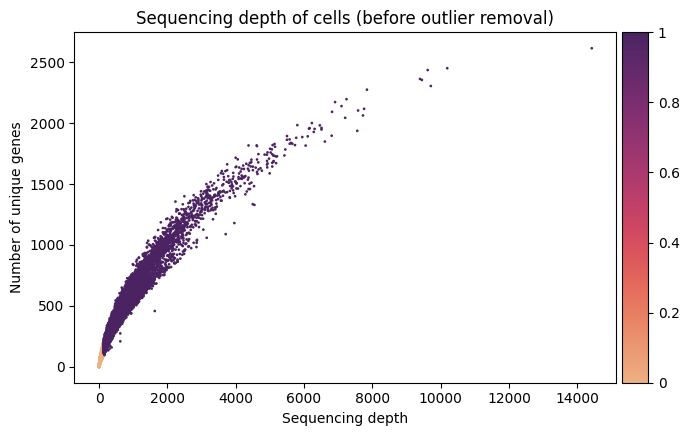

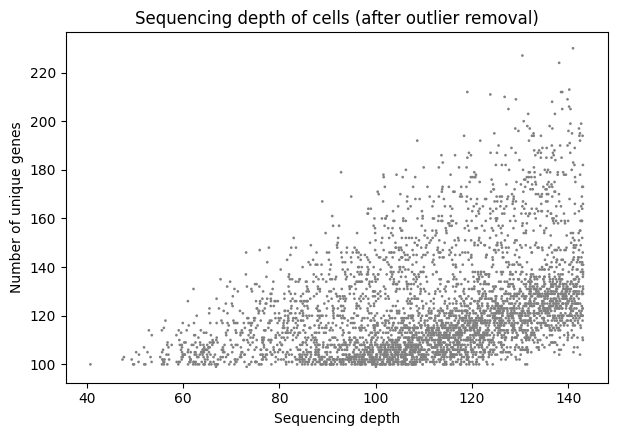

In [193]:
g = sc.pl.scatter(data_all, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="flare", title="Sequencing depth of cells (before outlier removal)")
g.set(xlabel = "Sequencing depth")
g.set(ylabel="Number of unique genes")
plt.tight_layout()
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is not overdispersed. Therefore, we will use Poisson count splitting

In [194]:
# Save raw counts into a layer of the anndata
data_gene.layers["counts"] = data_gene.X.copy()

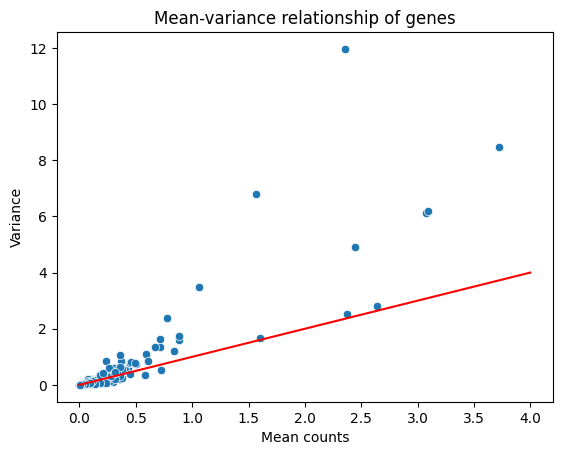

In [195]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

In [196]:
# See if a linear or quadratic relationship fits better 
mv_corr_lin = np.corrcoef(data_gene.var["mean_counts"], data_gene.var["var_counts"])[0,1]
mv_corr_sq = np.corrcoef(data_gene.var["mean_counts"]**2, data_gene.var["var_counts"])[0,1]

if mv_corr_sq > mv_corr_lin:
    is_overdispersed = True
else:
    is_overdispersed = False
    
if is_overdispersed:
    print("Data is overdispersed - use Negative Binomial count splitting")
else:
    print("Data is not overdispersed - use Poisson count splitting")


Data is not overdispersed - use Poisson count splitting


## Estimate negative binomial parameters for each gene

We use scTransform to estimate the dispersion parameter for each gene, which we will use for variance stabilization

In [197]:
import importlib
import tools.NB_est as nb

# Recharger le module nb après modification
importlib.reload(nb)

<module 'tools.NB_est' from '/Users/valentingoupille/Desktop/20_03/tools/NB_est.py'>

In [198]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform", seed=5678)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/valentingoupille/Desktop/20_03/.conda/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
Process SpawnPoolWorker-155:
Process SpawnPoolWorker-153:
Process SpawnPoolWorker-154:
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/valentingoupille/Desktop/20_03/.conda/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/valentingoupille/Desktop/20_03/tools/scTransform.py", line 3, in <module>
    import statsmodels.nonparametric.kernel_regression
  File "/Users/valentingoupille/Desktop/20_03/.conda/lib/python3.11/site-packages/statsmodels/nonparametric/kernel_regression.py", line 36, in <module>
    from scipy.stats.mstats import mquantiles
  File "/Users/valentingoupille/Desktop/20_03/.conda/lib/python3.11/site-packages/scipy/

KeyboardInterrupt: 

In [ ]:
data_gene.var

,names,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,is_scd_outlier,nb_overdisp,nb_overdisp_cutoff,nb_mean,nb_umi,Intercept_step1_sct,log_umi_step1_sct,dispersion_step1_sct
bs-dnaA,bs-dnaA,217,0.027448,0.027078,94.638003,111.082161,4.719232,217,0.021578,False,0.926588,0.926588,-8.980475,2.638351,NaN,NaN,NaN
bs-dnaN,bs-dnaN,70,0.010390,0.010336,98.270324,42.047257,3.762299,70,0.008628,False,0.919823,0.919823,-9.336214,2.318359,NaN,NaN,NaN
bs-rlbA,bs-rlbA,5,0.001235,0.001235,99.876452,5.000000,1.791759,5,0.001234,False,0.315849,0.315849,-10.885641,1.954487,NaN,NaN,NaN
bs-recF,bs-recF,150,0.030644,0.030184,96.293551,124.016664,4.828447,150,0.028778,False,0.927559,0.927559,-8.910996,2.630150,NaN,NaN,NaN
bs-remB,bs-remB,10,0.001658,0.001657,99.752903,6.711111,2.042662,10,0.001643,False,0.378405,0.378405,-10.547935,1.955440,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bs-mnmE,bs-mnmE,82,0.014509,0.014404,97.973808,58.716665,4.089611,82,0.012127,False,0.956769,0.956769,-9.345556,2.486343,NaN,NaN,NaN
bs-jag,bs-jag,283,0.050772,0.049526,93.007166,205.476166,5.330185,283,0.041709,False,0.910139,0.910139,-8.445815,2.673539,-2.829931,-0.073878,0.004359
bs-oxaAA,bs-oxaAA,91,0.018399,0.018232,97.751421,74.462301,4.323633,91,0.018610,False,0.948847,0.948847,-9.332614,2.575811,NaN,NaN,NaN
bs-rnpA,bs-rnpA,17,0.003571,0.003564,99.579936,14.450000,2.737609,17,0.003815,False,0.560492,0.560492,-10.087462,2.118120,NaN,NaN,NaN


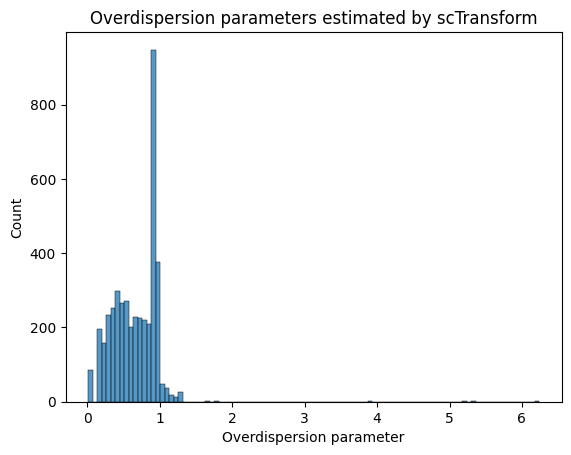

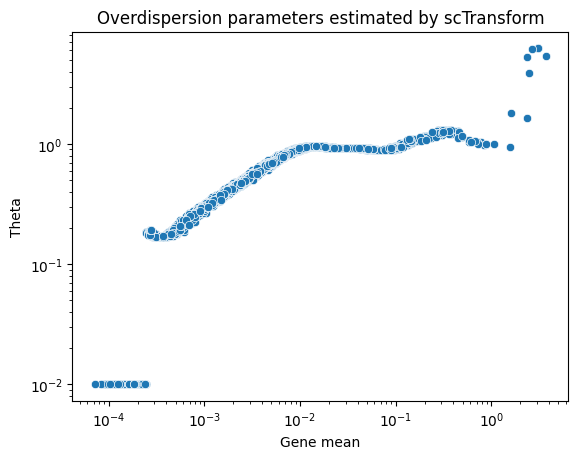

In [ ]:
# Quick diagnostic plot - maybe we can spot some outlier genes here that prompt further investigation
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log", yscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [ ]:
data_gene.X = data_gene.layers["counts"].copy()

## Normalization, VST, scaling and PCA

Normalize, scale and perform PCA on the data

In [ ]:
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)
if is_overdispersed:
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
else:
    # data_gene.X = sps.csr_matrix(np.sqrt(data_gene.X.toarray()))
    data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))

data_gene.layers["vst_counts"] = data_gene.X.copy()
sc.pp.scale(data_gene, max_value=10, zero_center=True)
sc.tl.pca(data_gene, svd_solver='arpack')

Histograms of cell sequencing depths before normalization, after VST and after scaling. The data should be more centered than before

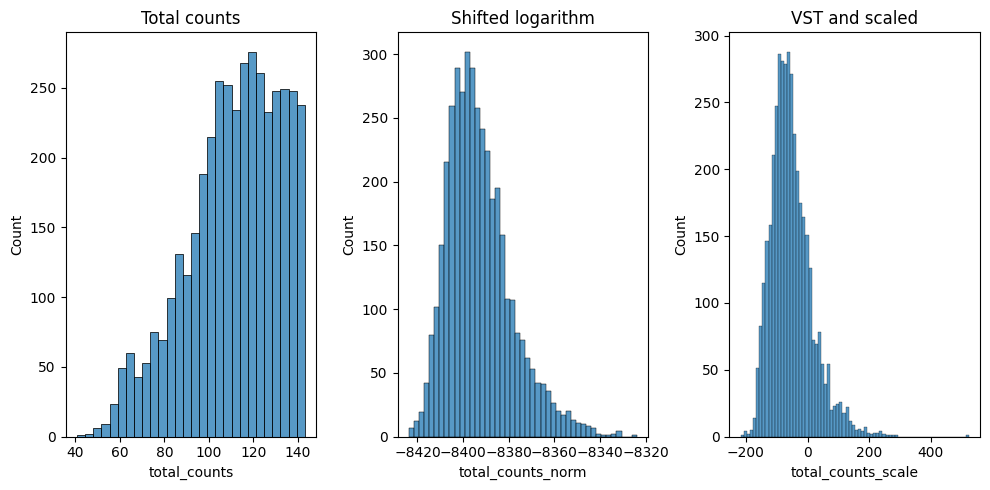

In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

This step creates a train and test dataset, which we use to determine the latent dimensionality and clustering resolution further down the line

In [ ]:
# Recharger le module nb après modification
importlib.reload(cs)
importlib.reload(ut)

In [ ]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [ ]:
if is_overdispersed:
    data_dist = "NB"
else:
    data_dist = "Poi"
data_train, data_test = cs.countsplit_adata(data_gene, data_dist=data_dist, beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'csc_matrix'

Process the data in the same way as the fulld dataset (Normalize, scale, PCA)

In [ ]:
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
if is_overdispersed:
    data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_train.X = sps.csr_matrix(np.sqrt(data_train.X.toarray()))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
if is_overdispersed:
    data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
else:
    data_test.X = sps.csr_matrix(np.sqrt(data_test.X.toarray()))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

In [ ]:
sc.pl.pca(data_train, title="Training data")
plt.show()

sc.pl.pca(data_test, title="Test data")
plt.show()

### Principal component selection

Select the optimal latent dimensionality k - the curve below should have a nice minimum

In [ ]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")
data_gene.uns["BacSC_params"] = {"k_opt": k_opt}

In [ ]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

Plot the PCA of the full dataset

In [ ]:
sc.pl.pca(data_gene, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

We now select parameters for the UMAP embedding. This is done with scDEED (Xia et al., 2023). Depending on the grid of values to test, this might take a while (in this example about 30 minutes).
The results are checkpointed after each parameter set, so you can always extend your parameter range

A representative set of parameters is given below, so that this step can be skipped

In [ ]:
seed = 140
print(seed)

In [ ]:
n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(data_gene, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=seed, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed_tutorial")

Plot the scDEED results. The plot might not exhibit a clear minimum, but we still take the parameter combination that has the least number of dubiously embedded cells

In [ ]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [ ]:
# Use these parameters if you don't want to run scDEED
# n_neighbors_opt = 20
# min_dist_opt = 0.5

In [ ]:
# Save parameters to data object
data_gene.uns["BacSC_params"]["n_neighbors_opt"] = n_neighbors_opt
data_gene.uns["BacSC_params"]["min_dist_opt"] = min_dist_opt

Compute and plot the resulting UMAP. The coloring by embedding reliability is only possible, if scDEED was performed

NOTE: UMAPs are rotation/mirroring invariant, so they might appear slightly different every time

In [ ]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=3456)


In [ ]:
# sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
# plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

**Checkpoint** 

Save the data to disk and read it again

In [ ]:
data_gene.write(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")

In [ ]:
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")
data_gene

## Clustering

We now apply Leiden clustering to the data. For this, we need to find a resolution parameter that points out the clusters in the data well

### Train/test-split for clustering

We apply the UMAP embedding with the previously calculated parameters to the train and test data.

In [ ]:
k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]

sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

In [ ]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

This step might also take a few minutes, based on the size of the data. You can also adjust the range of considered resolutions

In [ ]:
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)
print(f"Resolutions to test: {resolutions}")

#234
co.cluster_train_test(data_train, data_test, resolutions, alg="leiden", random_state=234)

In [ ]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

Compute modularities on train data for each clustering and select resolution with biggest increase in resolution on train data over a random clustering

In [ ]:
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions, random_seed=1234)

print(f"Optimal resolution {res_opt}")


In [ ]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

In [ ]:
# Checkpoint value for resolution to reduce computation time
res_opt = 0.23
data_gene.uns["BacSC_params"]["res_opt"] = res_opt


### Apply clustering to full dataset

In [ ]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt", random_state=1234)

In [ ]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

In [ ]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

**Checkpoint**

Save the data to disk and read it again

In [ ]:
data_gene.write(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")

## Attach feature table

In [ ]:
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")
data_gene

In [ ]:
# Adjust the path to the feature table
feature_table = pd.read_csv("../data/MOBA_scRNAseq/P_aeruginosa_PAO1_feature_table.tsv", sep="\t")
feature_table = feature_table[["Locus tag", "Protein accession", "Name", "Symbol"]]
feature_table["Locus tag"] = [str(x) for x in feature_table["Locus tag"]]
feature_table

In [ ]:
df3=data_gene.var.reset_index().merge(feature_table, how='left', left_on='index', right_on='Symbol').drop_duplicates("index").set_index("index")
data_gene.var = df3
data_gene.var

Save final dataset

In [ ]:
data_gene.write(data_path + "/filtered_data_maxpool_processed_tutorial.h5ad")

This concludes the main BacSC pipeline. To perform differential expression analysis, continue with the clustering analysis tutorial.